## Introduction

## Data preparation

In [1]:
# !pip install workalendar
# !pip install openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from workalendar.europe import Poland

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

### Loading the dataset

In [2]:
file_path = 'Car_accidents_Poland.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')
df['Date'] = pd.to_datetime(df['Date'],format='%d.%m.%Y')
df.set_index('Date', inplace=True)
df = df.sort_index()
df.index.freq = 'D'
df

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents
Date,,,,,,,
2022-06-15,18116,658,345,277,87,5,95
2022-06-16,15026,677,219,388,65,7,71
2022-06-17,18299,708,345,398,76,10,83
2022-06-18,18769,708,258,404,71,6,72
2022-06-19,16747,739,197,440,59,3,68
...,...,...,...,...,...,...,...
2024-06-14,17103,556,424,237,68,5,73
2024-06-15,17654,599,224,353,56,2,64
2024-06-16,15286,528,237,319,51,5,55


### Adding the exogenous data

In [3]:
df['Day_of_Week'] = df.index.day_name()
day_of_week_columns = pd.get_dummies(df['Day_of_Week'], dtype=float)
df = df.merge(day_of_week_columns, left_index=True, right_index=True)
# Initializing the Poland calendar, adding is_weekend column, is_holiday
cal = Poland()
df['is_holiday'] = df.index.to_series().apply(lambda x: cal.is_holiday(x)).astype(int)

df.tail()

,Interventions,Arrested_red-handed,Detained_wanted,Drivers_under_the_influence_of_alcohol,Road_accidents,Killed_in_accidents,Injured_in_accidents,Day_of_Week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,is_holiday
Date,,,,,,,,,,,,,,,,
2024-06-14,17103,556,424,237,68,5,73,Friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-15,17654,599,224,353,56,2,64,Saturday,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2024-06-16,15286,528,237,319,51,5,55,Sunday,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2024-06-17,16625,592,420,277,88,3,96,Monday,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2024-06-18,16698,500,450,225,85,3,90,Tuesday,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [4]:
cal = Poland()
cal.holidays(2022)

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 6), 'Trzech Kroli'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 1), 'Labour Day'),
 (datetime.date(2022, 5, 3), 'Constitution Day'),
 (datetime.date(2022, 6, 5), 'Pentecost Sunday'),
 (datetime.date(2022, 6, 16), 'Corpus Christi'),
 (datetime.date(2022, 8, 15), 'Assumption of Mary to Heaven'),
 (datetime.date(2022, 11, 1), 'All Saints Day'),
 (datetime.date(2022, 11, 11), 'Independence Day'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day')]

## Analysis for all Interventions

### Data visualization

C:\Users\kbocian\AppData\Local\Temp\ipykernel_2544\4094603792.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


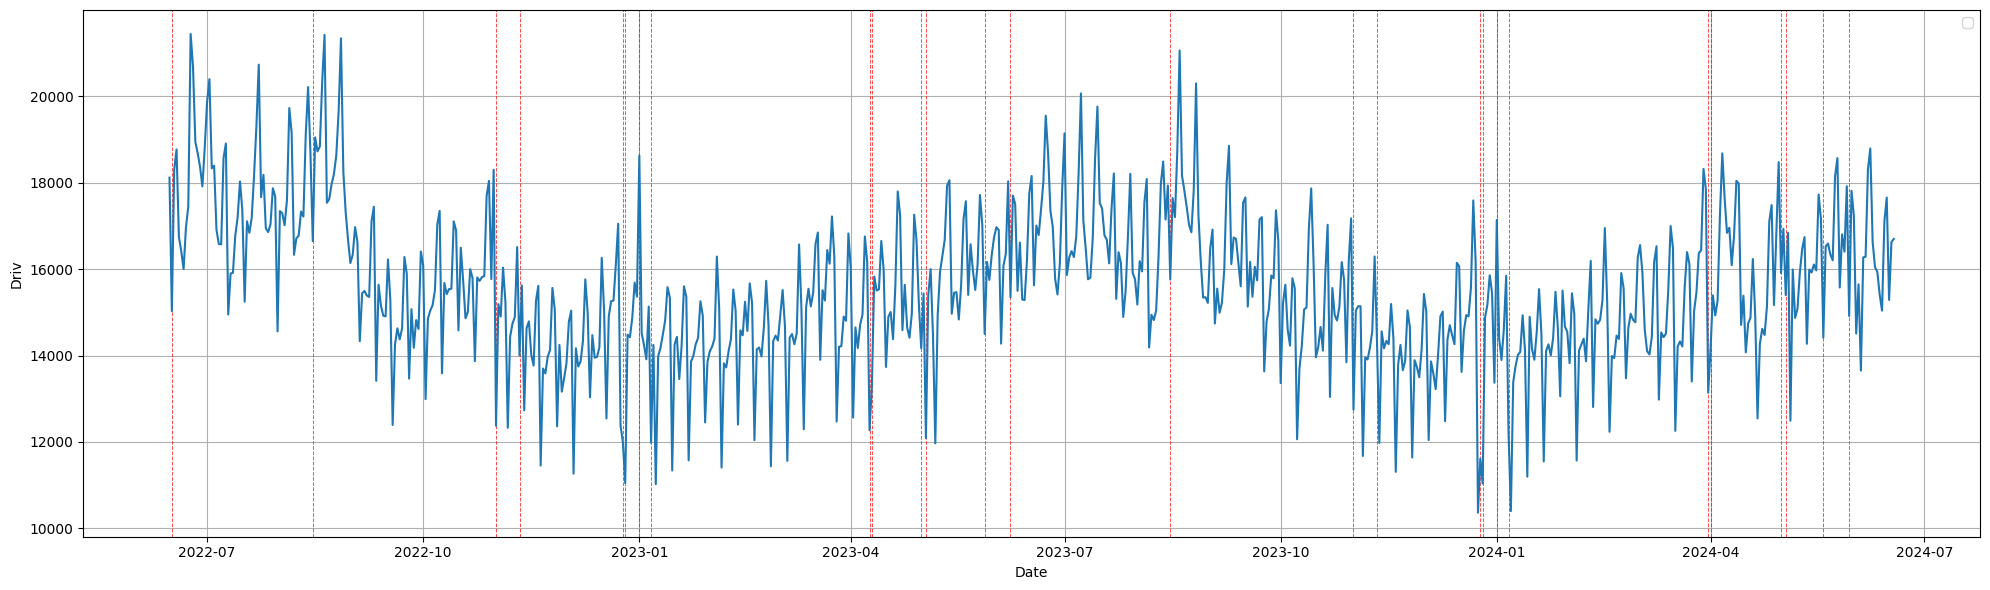

In [5]:
plt.figure(figsize=(20, 6)) 

holidays = df.index[df['is_holiday'] == True]
for holiday in holidays:
    plt.axvline(x=holiday, color='red', linestyle='--', linewidth=0.7, alpha=0.7)

plt.plot(df.index, df["Interventions"])
plt.xlabel('Date')
plt.ylabel('Driv')
plt.title('')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [6]:
# fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20), sharex=True)
# holidays = df.index[df['is_holiday'] == True]
# weekends = df.index[df['is_weekend'] == True]

# for i, col in enumerate(columns):
#     df[col].plot(ax=axes[i], title=col.strip(), legend=False)
#     axes[i].set_ylabel(col.strip())
    
#     # Plot vertical lines on holidays
#     for holiday in holidays:
#         axes[i].axvline(x=holiday, color='r', linestyle='--', lw=1)
      
#     for weekend in weekends:
#         axes[i].axvline(x=weekend, color='g', linestyle='--', lw=1)

# plt.tight_layout()
# plt.show()

### Autoarima analysis

In [7]:
train = df.iloc[:-48]
test  = df.iloc[-48:]
len(train)

start=len(train)
end=start+len(test)-1
len(train)

687

In [8]:
model_all_interventions = auto_arima(
    df["Interventions"],
    exogenous = df[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q =5,
    seasonal=True,
    m=7,
    trace = True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1
)
model_all_interventions.summary()

C:\Users\kbocian\OneDrive - Capgemini\Desktop\University\venv\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12940.170, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12466.425, Time=1.79 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12592.692, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12938.171, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=12865.184, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=12375.514, Time=1.51 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=12432.317, Time=2.88 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=12236.550, Time=3.21 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=12641.827, Time=2.64 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=12440.362, Time=4.04 sec


KeyboardInterrupt: 

In [ ]:
model_all_interventions = SARIMAX(train['Interventions'], exog=train[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']], 
                      order=(2,1,0), seasonal_order=(1,0,1,7)).fit() #Best model:  ARIMA(2,1,0)(1,0,1)[7] intercept
model_all_interventions.summary()

In [ ]:
diagnostics = model_all_interventions.plot_diagnostics(figsize=(12, 12))

### Predicting for 4 months

In [ ]:
predictions_all_interventions=model_all_interventions.predict(start=start,exog=test[["is_holiday", 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']],end=end,dynamic=False).rename('SARIMAX')
ax=test['Interventions'].plot(figsize=(14,5))
predictions_all_interventions.plot(legend=True)
for x in test.query('is_holiday==1').index:
    ax.axvline(x=x,color='r')

In [ ]:
mean_absolute_percentage_error(test['Interventions'],predictions_all_interventions)*100